#### Carlos Enrique Jaramillo Aros

#### MCD - FAII

#### 1144180744

<a href="https://colab.research.google.com/github/armandoordonez/eda_couse/blob/main/Taller_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **4. Parcial final - Parte Practica**

### El Problema

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos

## **1. Carga de paquetes**

In [ ]:
#!pip install fastai wwf bayesian-optimization -q --upgrade

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error, r2_score
#!pip install fastai wwf bayesian-optimization -q --upgrade
from bayes_opt import BayesianOptimization
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.arima.model import ARIMA


In [2]:
import warnings

# Desactivar las advertencias específicas
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

import warnings

# Desactivar FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Desactivar RuntimeWarnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)


## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [3]:
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/FAII/ParcialFinal_Practica/Examen.csv?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = pd.read_csv(url, sep=',',index_col=0)
print(data.shape)
data.head()

(127, 2)


,producto1,producto2
1,4000.000000,3000.000000
2,3997.400893,3010.686220
3,3978.605317,3022.018584
4,3986.454125,3033.920990
5,3979.695678,3038.402098


## **3. Transformacion/Entendimiento de datos**

#### Transformacion de datos

In [4]:
#Dado que el modelo no exige una precision alta en los valores para mejor lectura, haremos un redondeo de valores

In [5]:
data = data.round(decimals=2)  

In [6]:
fecha_inicial = '2008-01-01'
periodos = data.shape[0]
frecuencia = 'M'  # Frecuencia mensual
fechas = pd.date_range(start=fecha_inicial, periods=periodos, freq=frecuencia)
data.index = fechas
data.head()

,producto1,producto2
2008-01-31,4000.00,3000.00
2008-02-29,3997.40,3010.69
2008-03-31,3978.61,3022.02
2008-04-30,3986.45,3033.92
2008-05-31,3979.70,3038.40


#### Entendimiento de datos

In [7]:
data.shape

(127, 2)

In [8]:
print(data.dtypes)

producto1    float64
producto2    float64
dtype: object


In [9]:
data.duplicated().sum()

0

In [10]:
data.isna().sum()

producto1    0
producto2    0
dtype: int64

#### Graficos

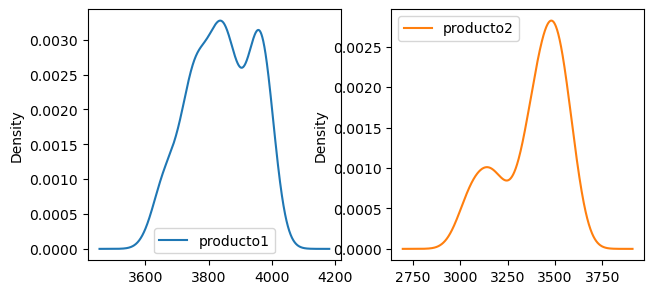

In [11]:
data.plot(kind='kde', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(15,15))
plt.show()

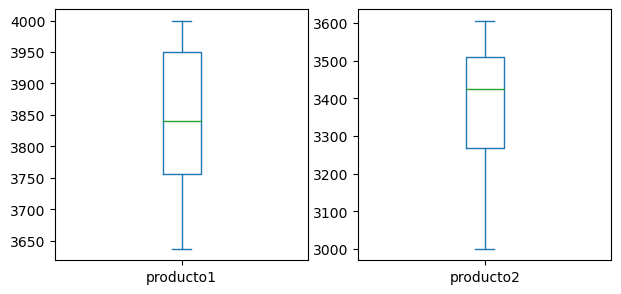

In [12]:
data.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(15,15))
plt.show()

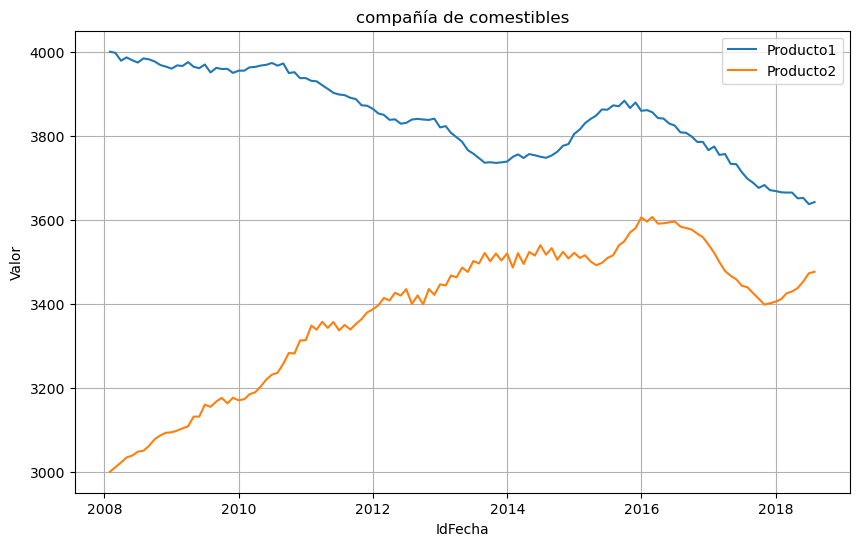

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['producto1'], label='Producto1')
plt.plot(data.index, data['producto2'], label='Producto2')
plt.title('compañía de comestibles')
plt.xlabel('IdFecha')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

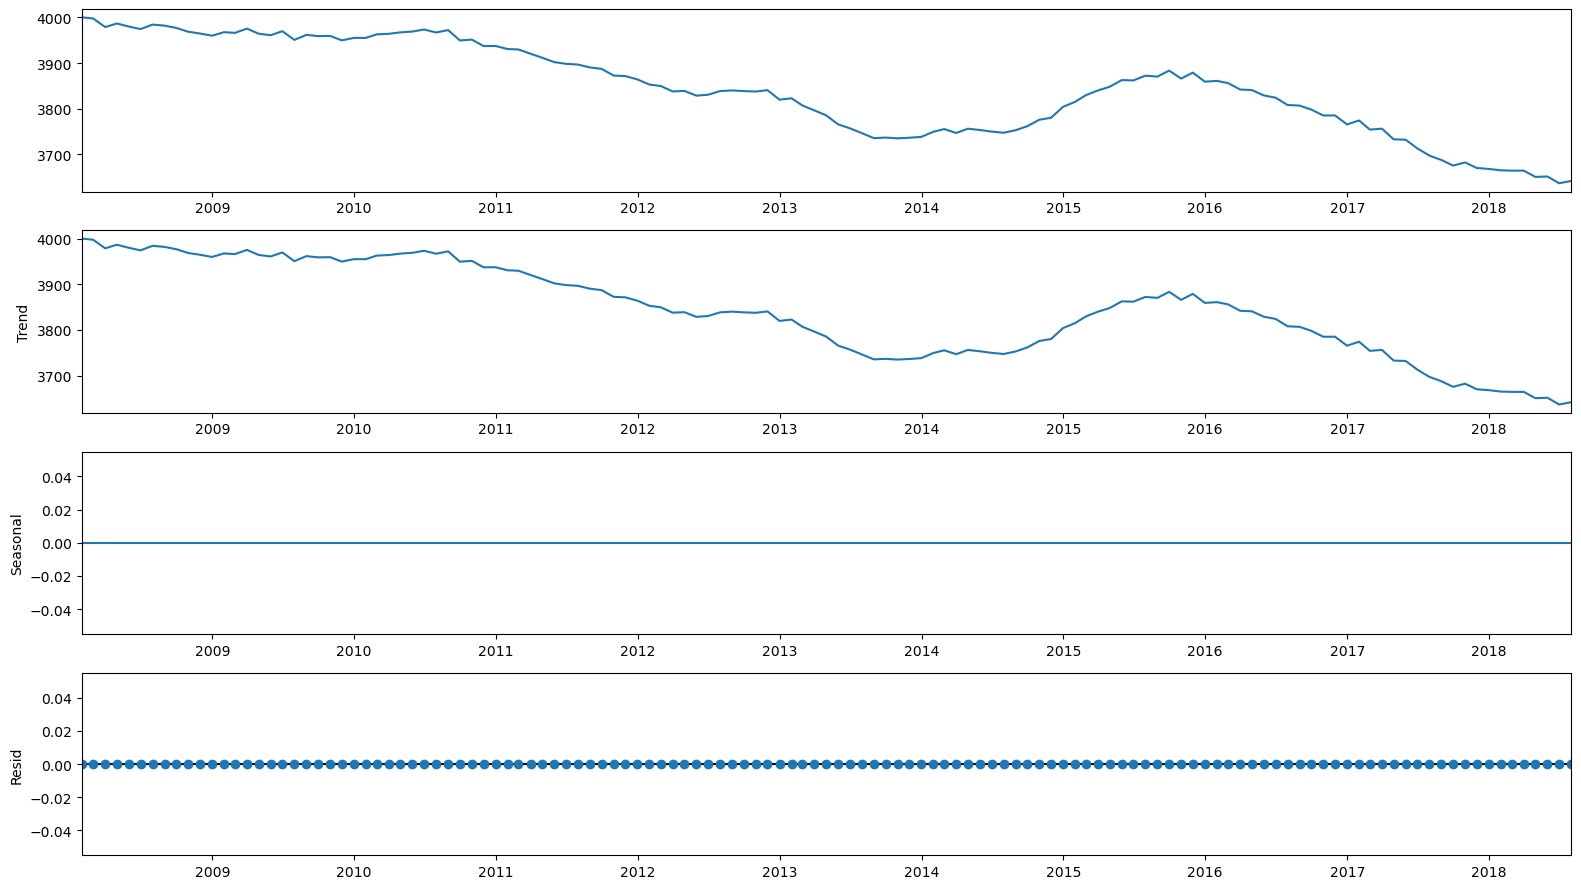

In [14]:
td_componentes = seasonal_decompose(data[["producto1"]],model="additive",period=1)
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

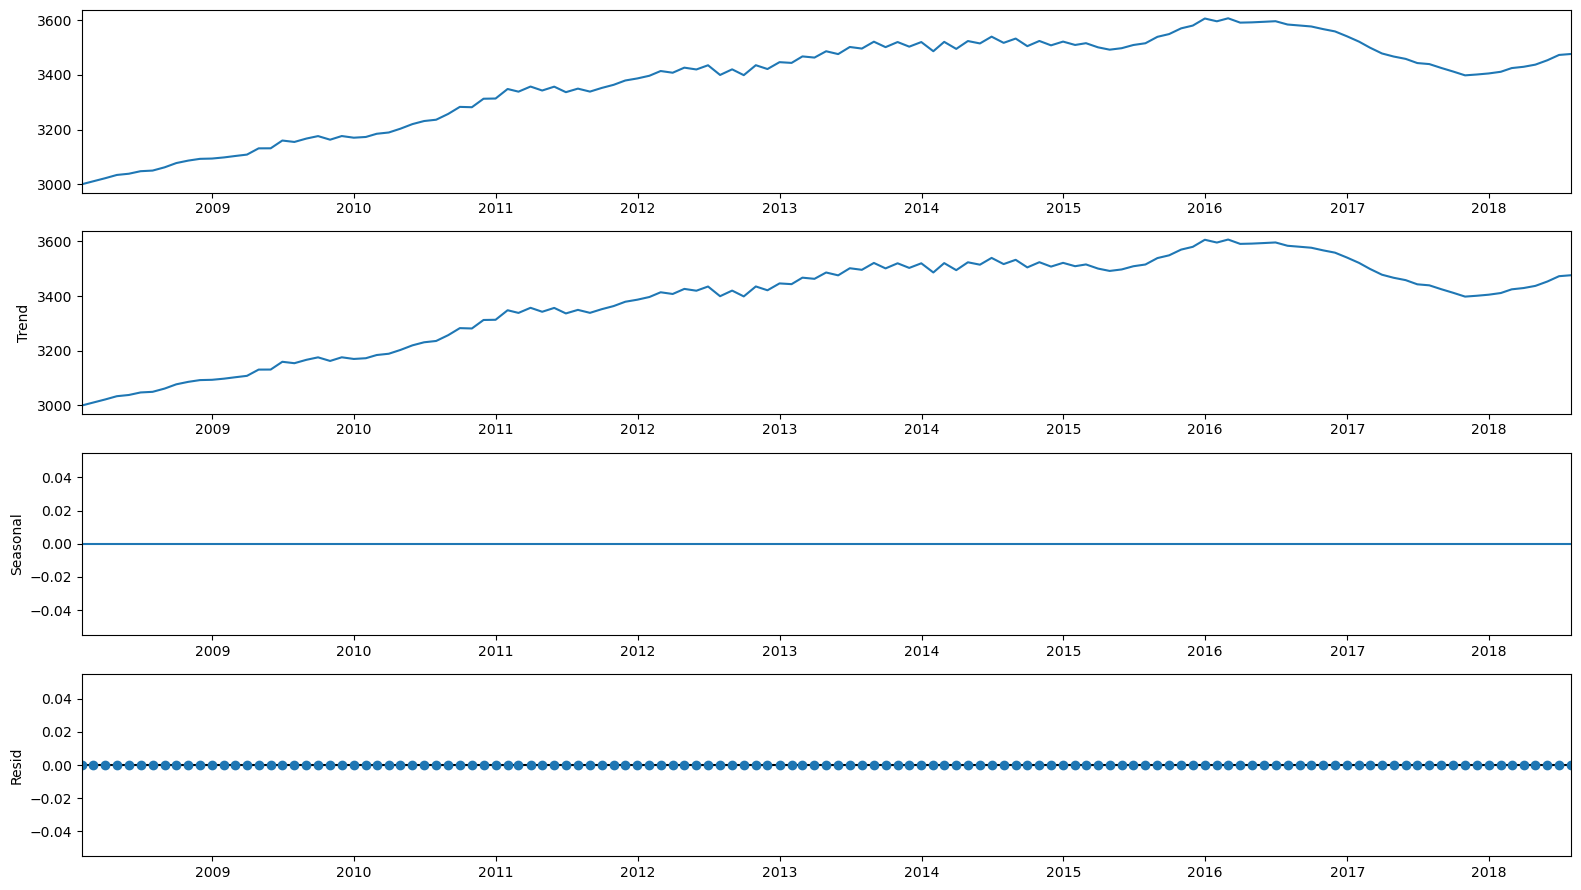

In [15]:
td_componentes = seasonal_decompose(data[["producto2"]],model="additive",period=1)
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

### Validaciones Iniciales

Podemos observar una tendencia no lineal de los datos para el producto1 aparentemente decreciente y para el producto2 aparentemente creciente.

## **4. Metodos de Evaluacion**

#### División de datos
Esto seria poco util, seria ideal usar ventana movil, solo se deja por mostrar cuales seria esta **ventan fija**

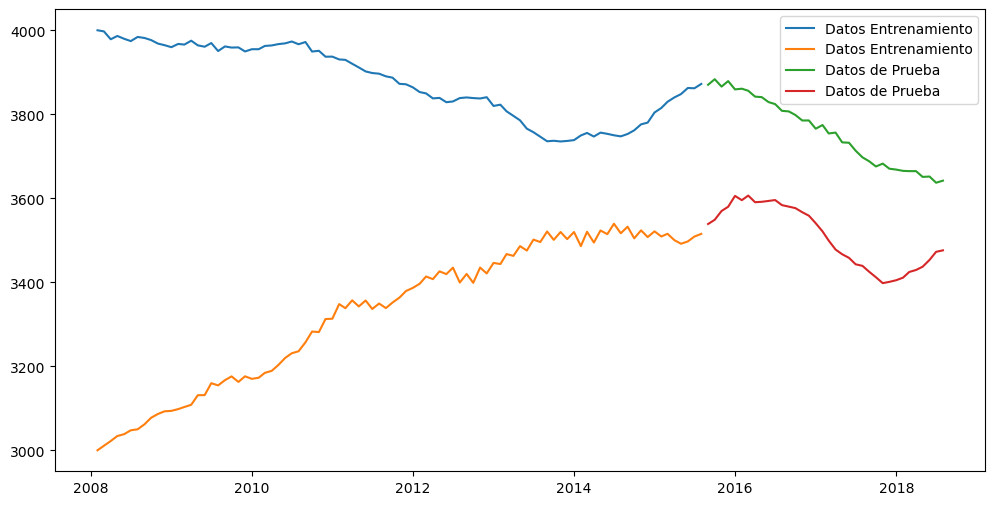

In [16]:
train_len = 91
train_td = data[:train_len]
test_td = data[train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

#### Arreglo para almacenar resultados

In [17]:
Resultados_columnas = ['Modelo', 'Configuración', 'RMSE', 'Coef R2']
Resultados = pd.DataFrame(columns=Resultados_columnas)

#### Protocolo de evaluacion
**Ventana Movil** usando Optimizacion Bayesiana

## **5. Modelos**

#### Modelos ARIMA

In [18]:
'''
Funcion que se encarga de entrenar el modelo y devolver las predicciones para luego calcular metricas.
'''
def pto_evaluacion_arima(data, w, h, P=1, I=1, Q=1):
    fore_all = []
    rmse_all = []
    test_values = []
    fore_values = []
    if P is None:
        P = 0 

    if I is None:
        I = 0 

    if Q is None:
        Q = 0 

    for i in range(0, w):
        train = data[(-w - h + i):(-w + i)]
        test = data.iloc[-w + i + h]
        model = ARIMA(train, order=(P, I, Q))
        results = model.fit()

        forecast = results.get_forecast(steps=1)

        fore = forecast.predicted_mean.values[0]
        

        fore_all.append(fore)
        test_values.append(test)
        fore_values.append(fore)

    r2 = r2_score(test_values, fore_values)
    rmse = np.sqrt(mean_squared_error(test_values, fore_values))
    return fore_all, rmse, r2

Usaremos una ventana de tamaño (w) **20** con un h de **1**. para una prueba local

In [19]:
#Prueba manual de ventana movil
result_fore, result_rmse, result_r2 = pto_evaluacion_arima(data['producto1'], w=20, h=1, P=1, I=2, Q=1)

print ("Forecasts :",result_fore,"\n\nRMSE: ",result_rmse,"\n\nCoef. R2: ", result_r2)

Forecasts : [5677.965946327026, 5648.505941417028, 5661.510943584528, 5631.49593858203, 5634.645939107029, 5599.6959332820325, 5598.345933057033, 5569.950928324535, 5546.235924372037, 5531.790921964539, 5513.565918927041, 5523.79592063204, 5505.585917597041, 5502.495917082041, 5497.905916317041, 5496.945916157042, 5496.915916152042, 5476.320912719543, 5477.685912947043, 5455.575909262045] 

RMSE:  1848.5945448193117 

Coef. R2:  -559.5296220031202


BlackBox para entrenar con Optimziacion Bayesiana

In [20]:
def entrenar_arima(P, I, Q):
    data = pd.DataFrame({'producto1': np.random.rand(100)})  # Data de ejemplo
    w = 20
    h = 1
    result_fore, result_rmse, result_r2 = pto_evaluacion_arima(data['producto1'], w, h, int(P), int(I), int(Q))
    return -result_rmse

In [21]:
pbounds = {'P': (1, 3), 'I': (1, 3), 'Q': (1, 3)}

In [22]:
optimizer = BayesianOptimization(
    f=entrenar_arima,
    pbounds=pbounds,
    random_state=1234,
    verbose=2
)

In [23]:
optimizer.maximize(init_points=3, n_iter=100)
best_params = optimizer.max['params']
best_params['P'] = int(best_params['P'])
best_params['I'] = int(best_params['I'])
best_params['Q'] = int(best_params['Q'])

|   iter    |  target   |     I     |     P     |     Q     |
-------------------------------------------------------------
| 1         | -0.5121   | 1.383     | 2.244     | 1.875     |
| 2         | -0.5842   | 2.571     | 2.56      | 1.545     |
| 3         | -0.5435   | 1.553     | 2.604     | 2.916     |
| 4         | -0.4025   | 1.236     | 2.208     | 1.904     |
| 5         | -0.6554   | 2.833     | 2.234     | 1.584     |
| 6         | -0.4546   | 1.179     | 2.171     | 1.992     |
| 7         | -0.4602   | 1.537     | 1.177     | 1.355     |
| 8         | -0.359    | 1.133     | 2.217     | 1.81      |
| 9         | -0.4383   | 1.086     | 2.418     | 1.827     |
| 10        | -0.6123   | 2.485     | 1.33      | 2.576     |
| 11        | -0.3205   | 1.152     | 2.032     | 1.691     |
| 12        | -0.5855   | 2.251     | 1.458     | 2.341     |
| 13        | -0.3651   | 1.863     | 2.158     | 2.301     |
| 14        | -0.3824   | 1.009     | 2.104     | 1.495     |
| 15    

In [24]:
print(best_params)

{'I': 1, 'P': 2, 'Q': 1}


In [25]:
# Get the top 5 results
top_results = sorted(optimizer.res, key=lambda x: x['target'])[:5]
best_parameters_ = []
for i, res in enumerate(top_results):
   
    # Cast the best parameters to integers
    best_ = res['params']
    best_['P'] = int(best_['P'])
    best_['I'] = int(best_['I'])
    best_['Q'] = int(best_['Q'])
    best_parameters_.append(best_)

print(best_parameters_)

[{'I': 2, 'P': 1, 'Q': 1}, {'I': 2, 'P': 2, 'Q': 1}, {'I': 2, 'P': 2, 'Q': 2}, {'I': 2, 'P': 2, 'Q': 1}, {'I': 2, 'P': 2, 'Q': 1}]


In [26]:
# Lista para almacenar los resultados
resultados_lista = []

# Iterar sobre las mejores configuraciones
for i, best_params in enumerate(best_parameters_):
    # Obtener las métricas para cada configuración
    result_fore, result_rmse, result_r2 = pto_evaluacion_arima(data['producto1'], w=20, h=6, **best_params)
    
    # Agregar resultados a la lista
    resultados_lista.append({'Modelo': f'ARIMA {i+1}', 
                             'Configuración': f"P={best_params['P']}, I={best_params['I']}, Q={best_params['Q']}", 
                             'RMSE': result_rmse, 
                             'Coef R2': result_r2})

# Concatenar la lista de resultados en un DataFrame
Resultados = pd.concat([Resultados, pd.DataFrame(resultados_lista)], ignore_index=True)


In [27]:
Resultados

,Modelo,Configuración,RMSE,Coef R2
0,ARIMA 1,"P=1, I=2, Q=1",187.737036,-0.649059
1,ARIMA 2,"P=2, I=2, Q=1",188.802853,-0.667836
2,ARIMA 3,"P=2, I=2, Q=2",188.830730,-0.668328
3,ARIMA 4,"P=2, I=2, Q=1",188.802853,-0.667836
4,ARIMA 5,"P=2, I=2, Q=1",188.802853,-0.667836


#### Modelos suavizacion ETS

In [28]:
def pto_evaluacion_ets(data, w, h,error,trend,seasonal,alpha,beta,gamma):
    alpha = round(alpha,2)
    beta = round(beta,2)
    gamma = round(gamma,2)
    error1=["add","mul"]
    trend1=["add","mul",None]
    seasonal1=["add","mul",None]
    #print("error:",error1[round(error)])
    #print("trend:",trend1[round(trend)])
    #print("seasonal:",seasonal1[round(seasonal)])
    fore_all = []
    rmse_all = []
    test_values = []
    fore_values = []


    for i in range(w, len(data) - h + 1):
        train = data.iloc[i - w:i]
        test = data.iloc[i + h - 1]
        model = ETSModel(endog=train,
                        error=error1[round(error)],
                        trend=trend1[round(trend)],
                        seasonal=seasonal1[round(seasonal)])
        params = {'smoothing_level':alpha,
                 'smoothing_trend':beta,
                 'smoothing_seasonal':gamma}
        if trend1[round(trend)]==None:
            params.pop('smoothing_trend')
        if seasonal1[round(seasonal)]==None:
            params.pop('smoothing_seasonal')
            
        model_result = model.fit_constrained(params,initialization_method='estimated')

        point_forecast=model_result.forecast(1)

        fore_all.append(point_forecast)
        test_values.append(test)
        fore_values.append(point_forecast)
        
    r2 = r2_score(test_values, fore_values)
    rmse = np.sqrt(mean_squared_error(test_values, fore_values))

    return fore_all, rmse, r2
            

In [29]:
result_fore, result_rmse, result_r2 = pto_evaluacion_ets(data['producto1'], w=124,h=1,
                                error= 0,
                                trend= 1,
                                seasonal= 2,
                                alpha =0.01,
                                beta = 0.1,
                                gamma = 0.0001)
        #error,trend,seasonal,alpha,beta,gamma
print ("Forecasts :",result_fore,
       "\n\nRMSE: ",result_rmse,
       "\n\nCoef. R2: ", result_r2)

Forecasts : [2018-05-31    3614.035786
Freq: M, dtype: float64, 2018-06-30    3608.268734
Freq: M, dtype: float64, 2018-07-31    3605.34808
Freq: M, dtype: float64] 

RMSE:  34.623558043036816 

Coef. R2:  -30.94776170892785


In [30]:
pbounds_ets = {'error': (0, 1),
           'trend': (0, 2),
           'seasonal': (2, 2), # mantendremos 2 dado que en la desc de datos no vimos estacionalidad
           'alpha': (0.01, 0.99),
           'beta': (0.01, 0.99),
           'gamma': (0.01, 0.99)
          }#data, w, h,error,trend,seasonal,alpha,beta,gamma

In [31]:
def entrenar_ets(error,trend,seasonal,alpha,beta,gamma):
    data = pd.DataFrame({'producto1': np.random.rand(100)})  # Data de ejemplo
    w = 20
    h =1
    result_fore, result_rmse, result_r2 = pto_evaluacion_ets(data['producto1'], w, h,error,trend,seasonal,alpha,beta,gamma)
    return -result_rmse

In [32]:
entrenar_ets(1,2,2,0.01,0.1,0.01)

-0.29922804872716274

In [33]:
optimizerETS = BayesianOptimization(
    f=entrenar_ets,
    pbounds=pbounds_ets,
    random_state=1234,
    verbose=1
)

In [34]:
optimizerETS.maximize(init_points=3, n_iter=10)
best_params = optimizerETS.max['params']

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
| 6         | -0.3723   | 0.2266    | 0.2618    | 0.382     | 0.2512    | 2.0       | 0.7447    |
| 10        | -0.3641   | 0.8444    | 0.9214    | 0.1995    | 0.4772    | 2.0       | 1.591     |
| 12        | -0.3526   | 0.5107    | 0.03145   | 0.6554    | 0.9582    | 2.0       | 1.809     |


In [35]:
best_params

{'alpha': 0.5107120109466378,
 'beta': 0.03145386358740757,
 'error': 0.6553794328603266,
 'gamma': 0.9582033326749142,
 'seasonal': 2.0,
 'trend': 1.8094314814098773}

In [36]:
# Get the top 5 results
top_results = sorted(optimizerETS.res, key=lambda x: x['target'])[:5]
best_parameters_ = [
    {
        k: 'add' if k in ['seasonal', 'error', 'trend'] and int(v) == 0 else
           'mul' if k in ['seasonal', 'error', 'trend'] and int(v) == 1 else
           None if k in ['seasonal', 'error', 'trend'] and int(v) == 2 else v
        for k, v in res['params'].items()
    }
    for res in top_results
]

best_parameters = [
    {
        k: v
        for k, v in res['params'].items()
    }
    for res in top_results
]

In [37]:
# Lista para almacenar los resultados
resultados_lista = []

# Iterar sobre las mejores configuraciones
for i, (best_par, homologated_par) in enumerate(zip(best_parameters, best_parameters_)):
    # Obtener las métricas para cada configuración
    result_fore, result_rmse, result_r2 = pto_evaluacion_ets(data['producto1'], w=20, h=6, **best_par)

    # Agregar resultados a otra lista (homologados)
    resultados_lista.append({
        'Modelo': f'Suavizacion ETS {i+1} ',
        'Configuración': f"({homologated_par['error']}, {homologated_par['trend']},{homologated_par['seasonal']}), a={round(homologated_par['alpha'],3)}, B={round(homologated_par['beta'],3)}, g={round(homologated_par['gamma'],3)}",
        'RMSE': result_rmse,
        'Coef R2': result_r2
    })


In [38]:
# Concatenar la lista de resultados en un DataFrame
Resultados = pd.concat([Resultados, pd.DataFrame(resultados_lista)], ignore_index=True)
Resultados

,Modelo,Configuración,RMSE,Coef R2
0,ARIMA 1,"P=1, I=2, Q=1",187.737036,-0.649059
1,ARIMA 2,"P=2, I=2, Q=1",188.802853,-0.667836
2,ARIMA 3,"P=2, I=2, Q=2",188.830730,-0.668328
3,ARIMA 4,"P=2, I=2, Q=1",188.802853,-0.667836
4,ARIMA 5,"P=2, I=2, Q=1",188.802853,-0.667836
5,Suavizacion ETS 1,"(add, add,None), a=0.143, B=0.654, g=0.748",37.247329,0.815213
6,Suavizacion ETS 2,"(add, mul,None), a=0.281, B=0.796, g=0.868",36.661420,0.820981
7,Suavizacion ETS 3,"(add, mul,None), a=0.608, B=0.625, g=0.954",36.810360,0.819524
8,Suavizacion ETS 4,"(add, add,None), a=0.096, B=0.481, g=0.881",38.034471,0.807321
9,Suavizacion ETS 5,"(add, mul,None), a=0.301, B=0.435, g=0.408",37.734072,0.810352


#### Modelos tendencia polinomica grado n

In [42]:
def train_and_predict_poly(data,w,h, degree):
    #y = train_data["Ocupados"]
    fore_all = []
    rmse_all = []
    test_values = []
    fore_values = []
    month_dummies = pd.get_dummies(data.index.month, drop_first=True).set_index(data.index)

    for i in range(w, len(data) - h + 1):
        train = data.iloc[i - w:i].copy()
        x = np.linspace(1, train.shape[0], train.shape[0])
        train["x"] = x
        train["x2"] = x**2
       
        test = pd.DataFrame(data.iloc[i + h - 1:i + h])
        train_dummy = month_dummies[i - w:i]
        test_dummy = month_dummies[i + h - 1:i + h]
        y = train['producto1'] # En este caso se asumirá que llega la columna seleccionada
        
        X = sm.add_constant(pd.concat([train[["x","x2"]],train_dummy],axis=1))
        
        model = sm.OLS(y, X)
        result = model.fit()
        
        x_for= np.linspace((train.shape[0]+1),(train.shape[0]+h),h) # generando x's para predecir
        x_for_all = pd.DataFrame(np.stack((x_for, x_for**2),axis=1),columns=["x","x2"] ) # Dataframe de los x
        range_dates = pd.date_range(train.index[-1] + relativedelta(months=1), periods=len(test), freq='MS')
        x_for_all.set_index(test.index, inplace=True)
        
        X_for = sm.add_constant(pd.concat([x_for_all, test_dummy], axis=1))
        X_for = pd.concat([pd.Series(1, index=x_for_all.index, name='const'), x_for_all, test_dummy], axis=1) # como add constant no sirvio, lo agregamos manual
        X_for.set_index(test.index, inplace=True)  # Set the index after adding the constant
        # Realizar predicciones
        predictions = result.get_prediction(X_for).summary_frame(alpha=0.05)
        y_prd = predictions['mean']

        # Crear el DataFrame de predicciones
        preds = pd.DataFrame(np.column_stack([y_prd]))
        preds.columns = ['Point_forecast']
        preds.set_index(range_dates, inplace=True)

        # Calcular métricas de rendimiento
        y_test = test['producto1']
        print(preds,"<-pred\ntest->",y_test)
        y_test.index = range(len(y_test))
        test_values.append(y_test)
        fore_values.append(y_prd)
    
    #print(test_values)
    r2 = r2_score(test_values, fore_values)
    rmse = np.sqrt(mean_squared_error(test_values, fore_values))
    print(f"Grado del polinomio: {degree}")
    print(f"Coeficiente R2 : {r2}")
    print(f"RMSE : {rmse}")
    
    return True


# Ejemplo de uso con diferentes grados
train_and_predict_poly(data,5,1, degree=7)

            Point_forecast
2008-07-01     2188.546708 <-pred
test-> 2008-06-30    3974.22
Freq: M, Name: producto1, dtype: float64
            Point_forecast
2008-08-01     3431.627477 <-pred
test-> 2008-07-31    3984.1
Freq: M, Name: producto1, dtype: float64
            Point_forecast
2008-09-01     3445.818878 <-pred
test-> 2008-08-31    3981.7
Freq: M, Name: producto1, dtype: float64
            Point_forecast
2008-10-01     3447.917272 <-pred
test-> 2008-09-30    3976.71
Freq: M, Name: producto1, dtype: float64
            Point_forecast
2008-11-01     3443.006007 <-pred
test-> 2008-10-31    3968.33
Freq: M, Name: producto1, dtype: float64
            Point_forecast
2008-12-01     3428.160651 <-pred
test-> 2008-11-30    3964.54
Freq: M, Name: producto1, dtype: float64
            Point_forecast
2009-01-01     3418.624654 <-pred
test-> 2008-12-31    3959.77
Freq: M, Name: producto1, dtype: float64
            Point_forecast
2009-02-01     3414.854833 <-pred
test-> 2009-01-31    396

True

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Simulación de datos de entrenamiento
train = pd.DataFrame({'feature': np.arange(215, 221)})

# Grado del polinomio
degree = 5

x = np.linspace(1, train.shape[0], train.shape[0])
x_poly = np.column_stack([x**i for i in range(1, degree+1)])

# Agregar variables dummy y la constante
train_dummy = pd.get_dummies(train['feature'], prefix='x', drop_first=True)
X = sm.add_constant(pd.concat([pd.DataFrame(x_poly, columns=[f"x{i}" for i in range(1, degree+1)]), train_dummy], axis=1))

print(X)
